In [1]:
def half_vectorize(Cp):
    n = len(Cp)
    Cp = np.copy(Cp)
    Cp[np.triu_indices(n, k=1)] *= np.sqrt(2)
    return Cp[np.triu_indices(n)]

<IPython.core.display.Javascript object>


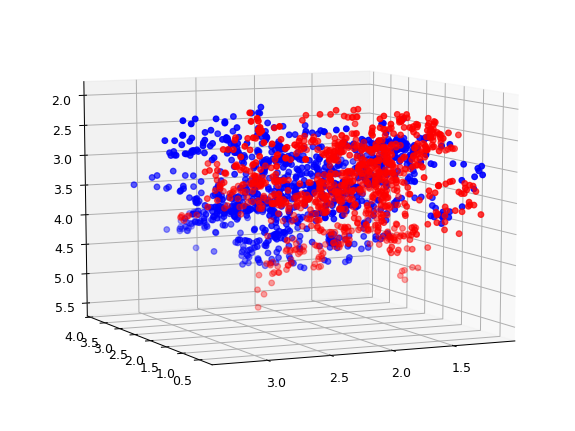

In [13]:
%matplotlib notebook

import numpy as np
import scipy.linalg
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

means = np.asarray([[0.5, 0.5], [0.53, 0.47]])
covs = np.asarray([[[2.1, 1.3], [1.3, 3.6]], [[1.9, 1.1], [1.1, 3.5]]])

def sample_multivariate_gaussian(n_samples, mean, cov):
    gmm = GaussianMixture(n_components=1, covariance_type='full')
    gmm.means_ = np.asarray([mean])
    gmm.covariances_ = np.asarray([cov])
    gmm.weights_ = np.asarray([1.])
    gmm.precisions_cholesky_ = np.linalg.inv(cov)
    return gmm.sample(n_samples)[0]

def generate_spd_matrices():
    positives = sample_multivariate_gaussian(1000, means[0], covs[0])
    negatives = sample_multivariate_gaussian(1000, means[1], covs[1])

    extract_cov = lambda X: np.asarray([np.cov(X[i-50:i].T) for i in range(50, len(X))])
    spd_pos, spd_neg = extract_cov(positives), extract_cov(negatives)

    vec_pos = np.asarray([half_vectorize(M) for M in spd_pos])
    vec_neg = np.asarray([half_vectorize(M) for M in spd_neg])
    return spd_pos, spd_neg, vec_pos, vec_neg

spd_pos, spd_neg, vec_pos, vec_neg = generate_spd_matrices()

fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(vec_pos[:, 0], vec_pos[:, 1], vec_pos[:, 2], c='blue')
ax.scatter(vec_neg[:, 0], vec_neg[:, 1], vec_neg[:, 2], c='red')
pyplot.show()

In [9]:
def _matrix_operator(Ci, operator):
    eigvals, eigvects = scipy.linalg.eigh(Ci, check_finite=False)
    eigvals = np.diag(operator(eigvals))
    return np.dot(np.dot(eigvects, eigvals), eigvects.T)

def sqrtm(Ci):
    return _matrix_operator(Ci, np.sqrt)

def logm(Ci):
    return _matrix_operator(Ci, np.sqrt)
    eigvals, eigvects = scipy.linalg.eigh(Ci, check_finite=False)
    eigvals = np.diag(operator(eigvals))
    return np.dot(np.dot(eigvects, eigvals), eigvects.T)

def invsqrtm(Ci):
    isqrt = lambda x: 1. / np.sqrt(x)
    return _matrix_operator(Ci, isqrt)

<IPython.core.display.Javascript object>


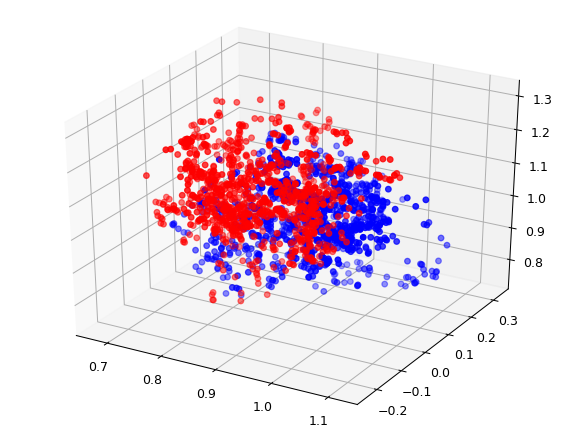

In [10]:
def log_c(Cp, sqrtCinv):
    return logm(np.dot(np.dot(sqrtCinv, Cp), sqrtCinv))

def project_matrices(spd_pos, spd_neg):
    C = spd_neg[0]
    sqrtCinv = scipy.linalg.inv(scipy.linalg.sqrtm(C))
    vec_pos = np.asarray([half_vectorize(log_c(Cp, sqrtCinv)) for Cp in spd_pos])
    vec_neg = np.asarray([half_vectorize(log_c(Cp, sqrtCinv)) for Cp in spd_neg])
    return vec_pos, vec_neg

vec_pos, vec_neg = project_matrices(spd_pos, spd_neg)

fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(vec_pos[:, 0], vec_pos[:, 1], vec_pos[:, 2], c='blue')
ax.scatter(vec_neg[:, 0], vec_neg[:, 1], vec_neg[:, 2], c='red')
pyplot.show()

In [12]:
def train_svm(X_pos, X_neg):
    y = np.concatenate((np.ones(len(X_pos)), np.zeros(len(X_neg))), axis=0)
    X = np.concatenate((X_pos, X_neg), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    svm = SVC(C=1, probability=True, kernel='linear')
    print("Training SVM... ", end='')
    svm.fit(X_train, y_train)
    print("done.")
    scores = svm.predict_proba(X_test)
    auc = roc_auc_score(y_test, scores[:, 1])
    print("ROC AUC score: %f" % auc)
    return auc

aucs = list()
for i in range(10):
    spd_pos, spd_neg, vec_pos, vec_neg = generate_spd_matrices()
    auc_1 = train_svm(vec_pos, vec_neg)
    vec_pos, vec_neg = project_matrices(spd_pos, spd_neg)
    auc_2 = train_svm(vec_pos, vec_neg)
    print("")
    aucs.append([auc_1, auc_2])

Training SVM... done.
ROC AUC score: 0.670584
Training SVM... done.
ROC AUC score: 0.667091

Training SVM... done.
ROC AUC score: 0.815817
Training SVM... done.
ROC AUC score: 0.811392

Training SVM... done.
ROC AUC score: 0.618140
Training SVM... done.
ROC AUC score: 0.640901

Training SVM... done.
ROC AUC score: 0.618212
Training SVM... done.
ROC AUC score: 0.635037

Training SVM... done.
ROC AUC score: 0.676669
Training SVM... done.
ROC AUC score: 0.675861

Training SVM... done.
ROC AUC score: 0.853591
Training SVM... done.
ROC AUC score: 0.830040

Training SVM... done.
ROC AUC score: 0.661545
Training SVM... done.
ROC AUC score: 0.638248

Training SVM... done.
ROC AUC score: 0.598737
Training SVM... done.
ROC AUC score: 0.623231

Training SVM... done.
ROC AUC score: 0.682604
Training SVM... done.
ROC AUC score: 0.692258

Training SVM... done.
ROC AUC score: 0.783806
Training SVM... done.
ROC AUC score: 0.785562



In [7]:
points = np.asarray(aucs)

print((points[:, 0] - points[:, 1]).mean())

0.00369396399072
